# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all-nohp.pkl"
bootstrap_cache = "data/bootstrap-all-nohp.pkl"
data_file = "all_vars.csv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv(data_file,index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(alpha=2000), 
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(alpha=30),
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(
            n_iter_no_change=20, max_depth=2,
            learning_rate=0.1, max_features=1, min_samples_leaf=20
            ),
        ),
    ]
    return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 638)
Treated data dimensions: (1295, 638)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [7]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=50,
    load_from_cache=False
)

Fitting ridge ...Done
Fitting lasso ...Done
Fitting gbr ...Done
Caching results to data/cross-val-all-nohp.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,25.49,4.56,0.22,0.15,0.14,0.16,"-685,511.88","541,257.51","-941,975.42","777,771.53"
lasso,-5.25,5.43,0.23,0.12,0.20,0.18,"-679,720.83","838,835.37","-867,648.82","722,714.25"
gbr,137.17,20.02,0.14,0.06,0.08,0.09,"-742,072.35","476,262.93","-1,003,446.96","643,075.06"


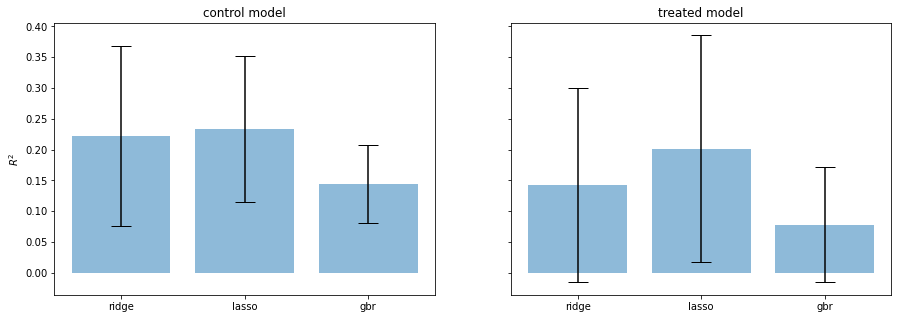

In [8]:
from direct_regression import visualise_ate
metrics, ate_vals = visualise_ate(results,X,evaluation_metrics);

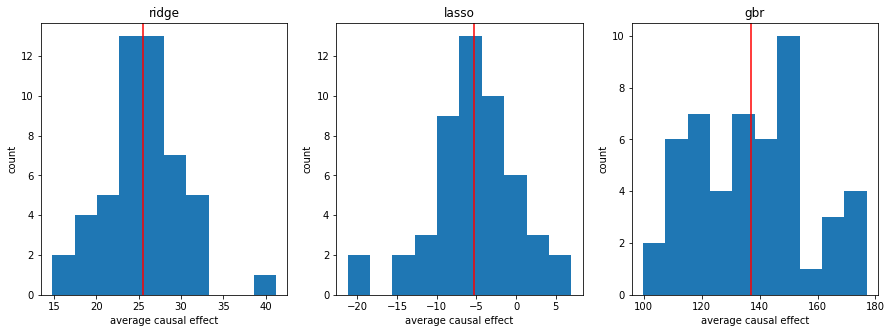

In [9]:
from direct_regression import plot_ate_distribution
plot_ate_distribution(ate_vals)

### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [11]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_

bootstrap_results = bootstrapped_cross_val(
    construct_models,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=5,
    load_from_cache=False,
    samples=50
)

Fitting ridge ...Done
Fitting lasso ...Done
Fitting gbr ...Done
Total time:18.239213943481445 seconds
Caching results to: data/bootstrap-all-nohp.pkl


####  Average treatment effects

In [12]:
from direct_regression import compute_ate
metrics, tau_estimatesb = compute_ate(bootstrap_results,X)
metrics

,ACE,ACE_std
ridge,35.767506,29.468315
lasso,3.762814,29.311333
gbr,138.364195,30.665307


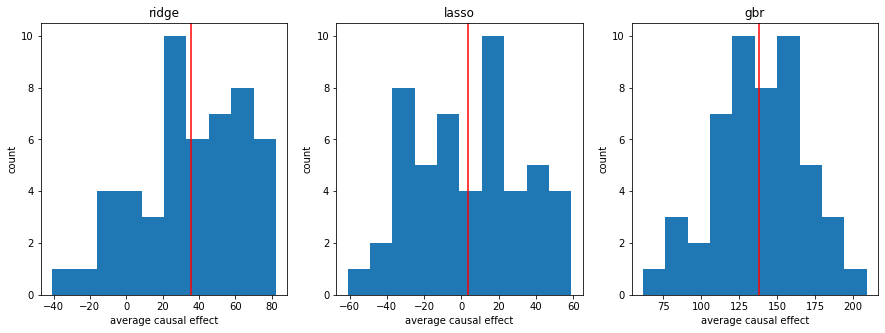

In [13]:
plot_ate_distribution(tau_estimatesb)